# Beyond a single LAMMPS calculation

Author: [jan-janssen](https://jan-janssen.com)

While pyiron can simplify the submission an analysis of individual calculation, for example in a lecture setting, the primary benefit of using pyiron is the ability to combine both the rapid prototyping of a simulation protocol as well as the up-scaling of the simulation protocol. So going beyond the previous example this, tutorial covers orchestrating a series of individual calculation and how pyiron can leverage advanced LAMMPS features like the Python library to accelerate your parameter studies. 

As an example we are going to calculate the energy volume dependence. This is typically used in ab-initio calculation to determine the equilibrium volume, equilibrium bulk modulus and its derivative. 

# Start with an empty Project

In analogy to the first tutorial we again start by importing the `Project` class from the `pyiron_atomistics` module:  

In [1]:
from pyiron_atomistics import Project

Afterwards we create a new `Project` instance for the following calculation named `evcurve` short for energy volume curve. We delete all previous calculation in this project, just to make sure everything is recalculated every time the jupyter notebook is executed rather than reloading the calculation: 

In [2]:
pr = Project(path="evcurve")
pr.remove_jobs(silently=True)

# Loop over different strain values
To measure the equilibrium volume, equilibrium bulk modulus and its derivative, we calculate the dependence of the energy on the volume. To change the volume we apply strains ranging from $-5\%$ to $+5\%$. Afterwards we fit the resulting energy volume dependence with a ploynomial. The minimum of this polynomial is the equilibrium volume, the second derivative is the bulk modulus and the third derivative corresponds to the pressure derivative of the bulk modulus. 

## Create a template job

As a first step a template job object is created. Here we keep the default settings for the LAMMPS job object which corresponds to a static calculation `run 0`. We only change the structure to apply the strain and the interatomic potential. 

In [3]:
job_template = pr.create.job.Lammps(job_name="lmp")
structure_template = pr.create.structure.ase.bulk(name="Al", cubic=True)
job_template.structure = structure_template

To choose an interatomic potential we again use the `list_potential()` function applied on the template job object. As the aluminium structure was already assigned to the job object, the `list_potential()` function only returns interatomic potentials which include interactions for aluminium:

In [4]:
job_template.list_potentials()

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1',
 '1999--Mishin-Y--Al--LAMMPS--ipr1',
 '2000--Landa-A--Al-Pb--LAMMPS--ipr1',
 '2000--Sturgeon-J-B--Al--LAMMPS--ipr1',
 '2002--Mishin-Y--Ni-Al--LAMMPS--ipr1',
 '2003--Lee-B-J--Al--LAMMPS--ipr1',
 '2003--Zope-R-R--Al--LAMMPS--ipr1',
 '2003--Zope-R-R--Ti-Al--LAMMPS--ipr1',
 '2004--Liu-X-Y--Al--LAMMPS--ipr1',
 '2004--Mishin-Y--Ni-Al--LAMMPS--ipr1',
 '2004--Mishin-Y--Ni-Al--LAMMPS--ipr2',
 '2004--Zhou-X-W--Al--LAMMPS--ipr2',
 '2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1',
 '2007--Silva-A-C--Al-Ni--LAMMPS--ipr1',
 '2008--Mendelev-M-I--Al--LAMMPS--ipr1',
 '2009--Kim-Y-M--Mg-Al--LAMMPS--ipr1',
 '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
 '2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Al--LAMMPS--ipr2',
 '2010--Lee-E--Fe-Al--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-1--

As a first step we select one of the aluminium potentials, here we choose the potential from Yuri Mishin, but that is just a personal preference: [1999--Mishin-Y--Al--LAMMPS--ipr1](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.65.224114) More details about the potential are again available via the publication list generated at the end of the project. 

In [5]:
job_template.potential = '1999--Mishin-Y--Al--LAMMPS--ipr1'

In addition to the interatomic potential we also once again select the flux enabled executable as we are using the flux kernel. Still for now we execute all the calculation inline with the primary python process. 

In [6]:
job_template.executable.version = '2022.11.03_flux'

## For loop

After defining the template job the next step is the execution of the for loop iterating over different strains. Here we import the numpy modul to generate an array of linearly spaced strains ranging from $-5\%$ to $+5\%$. 

In [7]:
import numpy as np

In [8]:
strain_lst = np.linspace(-0.05, 0.05, 11)

To iterate over the individual strains we have to copy both the LAMMPS job object, to create a new LAMMPS calculation for each strain as well as the structure object to gurantee that we always start from the equilibrium structure when we apply the selected strain. For the structure object we can use the simple `copy()` function. In contrast for copying the job object we use the `copy_to()` function. The `copy_to()` function receives two additional arguments, once the new job name for the copy of the job object `new_job_name` and in addition we do not want the job to be saved in the databased at this point, so we add the option `new_database_entry=False`. After the strain is applied on the structure using the `apply_strain()` function the updated structure is set to the structure property of the copied job and the job is executed by calling the `run()` function of the job object.

In [9]:
for strain in strain_lst: 
    job_strain = job_template.copy_to(
        new_job_name="lmp_" + str(1+strain).replace(".", "_"), 
        new_database_entry=False
    )
    structure_copy = structure_template.copy()
    structure_copy.apply_strain(strain)
    job_strain.structure = structure_copy 
    job_strain.run()

The job lmp_0_95 was saved and received the ID: 21752
The job lmp_0_96 was saved and received the ID: 21753
The job lmp_0_97 was saved and received the ID: 21754
The job lmp_0_98 was saved and received the ID: 21755
The job lmp_0_99 was saved and received the ID: 21756
The job lmp_1_0 was saved and received the ID: 21757
The job lmp_1_01 was saved and received the ID: 21758
The job lmp_1_02 was saved and received the ID: 21759
The job lmp_1_03 was saved and received the ID: 21760
The job lmp_1_04 was saved and received the ID: 21761
The job lmp_1_05 was saved and received the ID: 21762


All calcultion are summarized in the job table of the project object. In addition to the database ID this table contains the location of the job object given by the `projectpath` and `project` as well as the execution time and further details about the calculation. Still it is important to mention that the `job_table()` and the database in pyiron in general is just an index of all calculation executed by pyiron. The results of the calculation are stored in the HDF5 files of the individual calculation.

In [10]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,21752,finished,Al4,lmp_0_95,/lmp_0_95,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:36:58.578650,2023-08-11 09:36:59.299133,0.0,pyiron@ljubi#1,Lammps,0.1,None,None
1,21753,finished,Al4,lmp_0_96,/lmp_0_96,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:36:59.619686,2023-08-11 09:37:00.127617,0.0,pyiron@ljubi#1,Lammps,0.1,None,None
2,21754,finished,Al4,lmp_0_97,/lmp_0_97,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:37:00.457299,2023-08-11 09:37:00.962842,0.0,pyiron@ljubi#1,Lammps,0.1,None,None
3,21755,finished,Al4,lmp_0_98,/lmp_0_98,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:37:01.334911,2023-08-11 09:37:01.816432,0.0,pyiron@ljubi#1,Lammps,0.1,None,None
4,21756,finished,Al4,lmp_0_99,/lmp_0_99,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:37:02.136382,2023-08-11 09:37:02.686070,0.0,pyiron@ljubi#1,Lammps,0.1,None,None
5,21757,finished,Al4,lmp_1_0,/lmp_1_0,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:37:03.010487,2023-08-11 09:37:03.521878,0.0,pyiron@ljubi#1,Lammps,0.1,None,None
6,21758,finished,Al4,lmp_1_01,/lmp_1_01,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:37:03.844633,2023-08-11 09:37:04.355407,0.0,pyiron@ljubi#1,Lammps,0.1,None,None
7,21759,finished,Al4,lmp_1_02,/lmp_1_02,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:37:04.677583,2023-08-11 09:37:05.176471,0.0,pyiron@ljubi#1,Lammps,0.1,None,None
8,21760,finished,Al4,lmp_1_03,/lmp_1_03,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:37:05.500825,2023-08-11 09:37:06.030392,0.0,pyiron@ljubi#1,Lammps,0.1,None,None
9,21761,finished,Al4,lmp_1_04,/lmp_1_04,/home/janssen/pyiron/projects/,2023-08-11-lammps-workshop/evcurve/,2023-08-11 09:37:06.357974,2023-08-11 09:37:06.925999,0.0,pyiron@ljubi#1,Lammps,0.1,None,None


# Collect the results

After submitting and successfully executing the individual calculation the next step is collecting the results. While in principle it would be possible to collect the output required to plot the energy volume curve, namely the volume and the total energy at the end of each calculation, the goal of pyiron is to split the execution from the analysis of the calculation. This is particularly beneficial when the calculations can not be completed in the order of seconds but require multiple hours and might be submitted to the queuing system individually. 

## Iterate over jobs in project

To structure the analysis in the pyiron framework we recommend to follow the map-reduce pattern. This means we start by loading one job from the dataset, develop a set of functions we want to apply to all job objects to extract certain quantities and then map these functions to all job objects in a given project. By using the `inspect()` function rather than the `load()` function only a pointer to the HDF5 file of the job object is loaded in contrast to loading the whole job object. This results in a drastic speedup as explained in the next section. Here we use the name of the last job executed in the for loop to load the corresponding job. 

In [11]:
job_inspect = pr.inspect(job_strain.job_name)

Once the pointer to the HDF5 file is loaded we can browse the output and in particular the code-independent `generic` output to find the entries for the volume (`volume`) and the total energy (`energy_tot`). 

In [12]:
job_inspect["output/generic/volume"][0], job_inspect["output/generic/energy_tot"][0]

(76.901173453125, -13.0926766182116)

After we identified the properties we want to extract from the individual calculation we define one function per property, which takes a pointer to the HDF5 file of a job object as an input and returns the property it should extract:

In [13]:
def get_volume(job):
    return job["output/generic/volume"][0]

In [14]:
def get_energy_tot(job):
    return job["output/generic/energy_tot"][0]

In the map step these functions are applied to all jobs in a given project by iterating over the jobs in the project using the `iter_jobs()` function applied on the project object. The results are stored in two lists one for the volumes (`volume_lst`) and one for the total energies (`energy_lst`). 

In [15]:
volume_lst, energy_lst = [], []
for job in pr.iter_jobs():
    volume_lst.append(get_volume(job=job))
    energy_lst.append(get_energy_tot(job=job))

  0%|          | 0/11 [00:00<?, ?it/s]

As a next step we can visualize the aggregated data using the matplotlib library: 

In [16]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Energy (eV)')

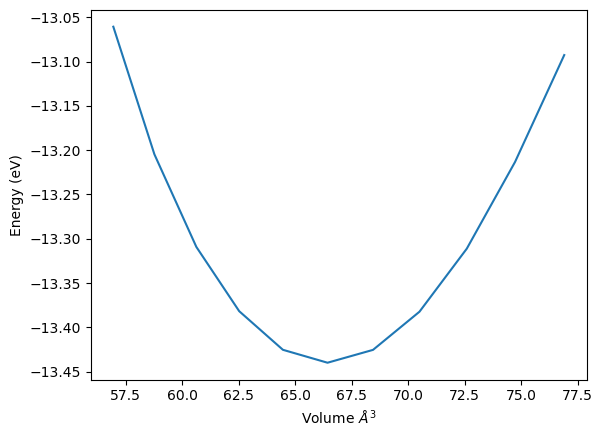

In [17]:
plt.plot(volume_lst, energy_lst)
plt.xlabel("Volume $\AA^3$")
plt.ylabel("Energy (eV)")

## Inspect mode 

While iterating over 11 job objects is sufficiently fast, the `iter_jobs()` function has an optional `convert_to_object` parameter. By setting the `convert_to_object` parameter to `False` the `iter_jobs()` function internally uses the `inspect()` function rather than the `load()` function. This can be several orders of magnitude faster depending on the size of your job objects: 

In [18]:
volume_lst, energy_lst = [], []
for job in pr.iter_jobs(convert_to_object=False):
    volume_lst.append(get_volume(job=job))
    energy_lst.append(get_energy_tot(job=job))

  0%|          | 0/11 [00:00<?, ?it/s]

The output is exactly the same, so we can use the same commands as above to plot the same energy volume curve.

Text(0, 0.5, 'Energy (eV)')

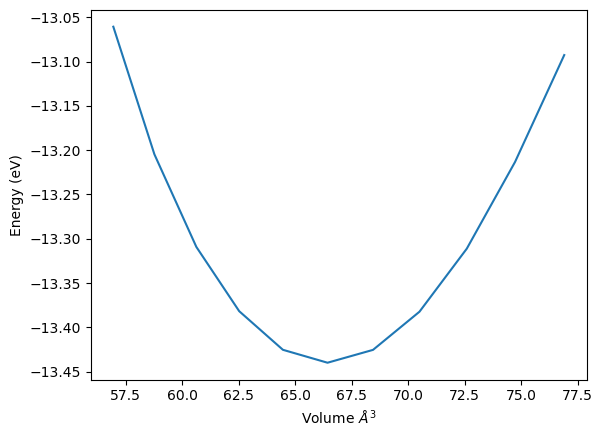

In [19]:
plt.plot(volume_lst, energy_lst)
plt.xlabel("Volume $\AA^3$")
plt.ylabel("Energy (eV)")

This ability to drastically accelerate the execution of your simulation workflows by setting specific parameters is a core feature for pyiron. By default we try to provide the users with as much flexibility as possible but at the same time we provide expert users with optional settings to drastically accelerate their simulation workflows.

## pyiron table 

To further simplify the analysis step, pyiron also provides the pyiron tables class. The advantage of this separate class is the ability to submit the analysis to the queuing system and receive the aggregated results as a `pandas.DataFrame` once the map-reduce step is completed. Again, for 11 calculation this might seem like an overhead, but for projects containing thousands of calculation this functionality is essential. The table object is created just like a job object directly from the project. 

In [20]:
table = pr.create.table()

Afterwards the functions defined above, which take a pointer to the HDF5 file of a job object as an input and return a single property are added to the `add` property using the dictionary notation. The keys defined for the individual functions are going to be columns of the resulting `pandas.DataFrame` and the individual calculation in the project correspond to the rows of the `pandas.DataFrame`. Once all functions are defined the table object can be executed using the `run()` function just like a job object and after the execution finished the `pandas.DataFrame` containing all the results is available via the `get_dataframe()` function. 

In [21]:
table.add["volume"] = get_volume
table.add["energy_tot"] = get_energy_tot
table.run()
df = table.get_dataframe()

The job table was saved and received the ID: 21763


Loading and filtering jobs:   0%|          | 0/12 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/11 [00:00<?, ?it/s]

The `pandas.DataFrame` contains the `volume` and the `energy_tot` as columns in addition to the `job_id` which is always included and each row represents one of the 11 calculation in the project.

In [22]:
df

,job_id,volume,energy_tot
0,21752,56.955528,-13.060681
1,21753,58.773123,-13.204749
2,21754,60.628981,-13.309295
3,21755,62.523502,-13.381820
4,21756,64.457084,-13.425410
5,21757,66.430125,-13.440000
6,21758,68.443024,-13.425492
7,21759,70.496180,-13.382455
8,21760,72.589991,-13.311268
9,21761,74.724856,-13.213377


In analogy to the plot above, the `pandas.DataFrame` can also be used to visualize the results using matplotlib. 

Text(0, 0.5, 'Energy (eV)')

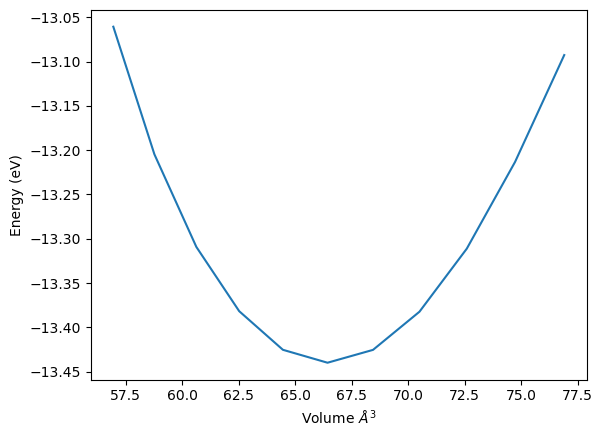

In [23]:
plt.plot(df["volume"], df["energy_tot"])
plt.xlabel("Volume $\AA^3$")
plt.ylabel("Energy (eV)")

Again using a `pandas.DataFrame` might look overly complicated for just plotting an energy volume curve, but the intention of this functionality is to analyse hundreds or thousands of calculation. In addition the `pandas.DataFrame` format is supported by a wide range of machine learning packages, so the output of the pyiron table can be directly integrated in an machine learning workflow. 

# Murnaghan class 

Still calculating energy volume curves is such a standard task in particular in the ab-initio community, that pyiron provides another abstraction layer. The `Murnaghan` job object named after the Murnaghan, named after the [Murnaghan equation of state](https://en.wikipedia.org/wiki/Murnaghan_equation_of_state) is a `GenericMaster` job object, which basically means it is a job object creating other job objects. 

In [24]:
murn = pr.create.job.Murnaghan(job_name="murn")

The `GenericMaster` job objects take a reference job as an input `ref_job` and internally copy this reference job using the `copy_to()` function as demonstrated above.

In [25]:
murn.ref_job = job_template

Beyond the `ref_job` the `Murnaghan` job object defines a series of further input arguments, like the number of sample points or the volume range which can all be set via the `input` property using the dictionary notation. 

In [26]:
murn.input

,Parameter,Value,Comment
0,num_points,11,number of sample points
1,fit_type,polynomial,"['polynomial', 'birch', 'birchmurnaghan', 'murnaghan', 'pouriertarantola', 'vinet']"
2,fit_order,3,order of the fit polynom
3,vol_range,0.1,relative volume variation around volume defined by ref_ham
4,axes,"[x, y, z]",Axes along which the strain will be applied
5,strains,None,List of strains that should be calculated. If given vol_range and num_points take no effect.
6,allow_aborted,0,"The number of child jobs that are allowed to abort, before the whole job is considered aborted."


After both the reference job and the input for the `GenericMaster` job object are defined the `GenericMaster` job object can be executed like any other job object by calling the `run()` function. In particular, this also means that the whole `GenericMaster` job object can be submitted to the queuing system to execute multiple individual calculation either in serial if the number of cores `job.server.cores` of the reference job is euqal to the number of cores of the `GenericMaster` job object `murn.server.cores` or in parallel if the number of cores for the `GenericMaster` job object is sufficiently large. 

In [27]:
murn.run()

The job murn was saved and received the ID: 21764
The job murn_0_9 was saved and received the ID: 21765
The job murn_0_92 was saved and received the ID: 21766
The job murn_0_94 was saved and received the ID: 21767
The job murn_0_96 was saved and received the ID: 21768
The job murn_0_98 was saved and received the ID: 21769
The job murn_1_0 was saved and received the ID: 21770
The job murn_1_02 was saved and received the ID: 21771
The job murn_1_04 was saved and received the ID: 21772
The job murn_1_06 was saved and received the ID: 21773
The job murn_1_08 was saved and received the ID: 21774
The job murn_1_1 was saved and received the ID: 21775


In addition to simplifying the submission and execution of the calculation the `Murnaghan` job object also provides utility functions like the ability to plot the energy volume curve directly using the `plot()` function. 

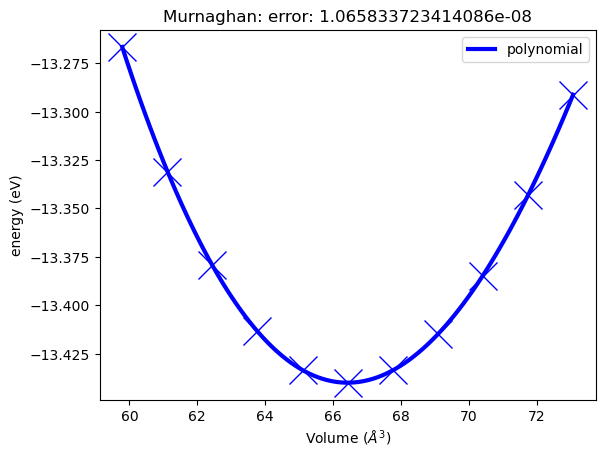

<Axes: title={'center': 'Murnaghan: error: 1.065833723414086e-08'}, xlabel='Volume ($\\AA^3$)', ylabel='energy (eV)'>

In [28]:
murn.plot()

# Loop over interatomic potentials

As already indicated in the beginning we can now combine the functionality of the `Murnaghan` job object and the pyiron table object and iterate over a series of interatomic potentials to compare their equilibrium properties. To do so we create a new project named `potentials`. Again in this project we delete all existing calculation to have a fresh start. 

In [29]:
pr = Project(path="potentials")
pr.remove_jobs(silently=True)

We restrict ourselves to the first ten interatomic potentials for aluminium from the `list_potentials()` function, to reduce the number of calculation. 

In [30]:
potential_lst = job_template.list_potentials()[:10]
potential_lst

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1',
 '1999--Mishin-Y--Al--LAMMPS--ipr1',
 '2000--Landa-A--Al-Pb--LAMMPS--ipr1',
 '2000--Sturgeon-J-B--Al--LAMMPS--ipr1',
 '2002--Mishin-Y--Ni-Al--LAMMPS--ipr1',
 '2003--Lee-B-J--Al--LAMMPS--ipr1']

In addition, we introduce another command to accelerate the execution. This command is switching the `run_mode` from `modal` which is the default to `interactive`. In terms of the LAMMPS execution this means, rather than writing input files and parsing output files we now use the LAMMPS Python interface and directly communicate with it using Python variables. This switch of `run_mode` drastically reduces the I/O overhead and consequently accelerates the calculations.  

In [31]:
job_template.server.run_mode.interactive = True

Now iterating over the list of interatomic potentials is as easy as iterating over the different strains in the previous example. We notice that rather than creating a single LAMMPS job object for each strain of a given `Murnaghan` job object, the interactive `run_mode` allows us to reuse the LAMMPS job object, resulting in only one LAMMPS job object for each `Murnaghan` job object. 

In [32]:
for i, potential in enumerate(potential_lst): 
    murn = pr.create.job.Murnaghan(job_name="murn_" + potential.replace("-", "_"))
    job_pot = job_template.copy_to(
        new_job_name="lmp_" + str(i), 
        new_database_entry=False
    )
    job_pot.potential = potential 
    murn.ref_job = job_pot
    murn.run()

The job murn_1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1 was saved and received the ID: 21776
The job murn_1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1_lmp_0 was saved and received the ID: 21777


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job murn_1996__Farkas_D__Nb_Ti_Al__LAMMPS__ipr1 was saved and received the ID: 21778
The job murn_1996__Farkas_D__Nb_Ti_Al__LAMMPS__ipr1_lmp_1 was saved and received the ID: 21779


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
2023-08-11 09:37:20,727 - pyiron_log - WARNING - Minimum could not be found!


The job murn_1997__Liu_X_Y__Al_Mg__LAMMPS__ipr1 was saved and received the ID: 21780
The job murn_1997__Liu_X_Y__Al_Mg__LAMMPS__ipr1_lmp_2 was saved and received the ID: 21781


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job murn_1998__Liu_X_Y__Al_Mg__LAMMPS__ipr1 was saved and received the ID: 21782
The job murn_1998__Liu_X_Y__Al_Mg__LAMMPS__ipr1_lmp_3 was saved and received the ID: 21783


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job murn_1999__Liu_X_Y__Al_Cu__LAMMPS__ipr1 was saved and received the ID: 21784
The job murn_1999__Liu_X_Y__Al_Cu__LAMMPS__ipr1_lmp_4 was saved and received the ID: 21785


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job murn_1999__Mishin_Y__Al__LAMMPS__ipr1 was saved and received the ID: 21786
The job murn_1999__Mishin_Y__Al__LAMMPS__ipr1_lmp_5 was saved and received the ID: 21787


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job murn_2000__Landa_A__Al_Pb__LAMMPS__ipr1 was saved and received the ID: 21788
The job murn_2000__Landa_A__Al_Pb__LAMMPS__ipr1_lmp_6 was saved and received the ID: 21789


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job murn_2000__Sturgeon_J_B__Al__LAMMPS__ipr1 was saved and received the ID: 21790
The job murn_2000__Sturgeon_J_B__Al__LAMMPS__ipr1_lmp_7 was saved and received the ID: 21791


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job murn_2002__Mishin_Y__Ni_Al__LAMMPS__ipr1 was saved and received the ID: 21792
The job murn_2002__Mishin_Y__Ni_Al__LAMMPS__ipr1_lmp_8 was saved and received the ID: 21793


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job murn_2003__Lee_B_J__Al__LAMMPS__ipr1 was saved and received the ID: 21794
The job murn_2003__Lee_B_J__Al__LAMMPS__ipr1_lmp_9 was saved and received the ID: 21795


/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(
/home/janssen/mambaforge/lib/python3.10/site-packages/pyiron_atomistics/lammps/interactive.py:131: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


Again analogy to analysing the energy volume curve above, we first start by analysing the `output` of a single murnaghan object and then define the functions which are applied to each `Murnaghan` job object afterwards. 

In [33]:
murn["output/equilibrium_energy"], murn["output/equilibrium_bulk_modulus"], murn["output/equilibrium_volume"]

(-13.440482175734004, 81.39064021275028, 66.17077428883863)

In [34]:
def get_equilibrium_energy(job):
    return job["output/equilibrium_energy"]

def get_equilibrium_volume(job):
    return job["output/equilibrium_volume"]

def get_equilibrium_bulk_modulus(job):
    return job["output/equilibrium_bulk_modulus"]

def get_potential_name(job):
    return job.job_name.split("murn_")[-1].replace("_", "-")

As the project now contains both LAMMPS job objects as well as the `Murnaghan` job objects we define an additional filter function, which filters the job objects based on the `hamilton` entry in the `database_entry`. The filter function again receives a the pointer to the HDF5 file of a job object and returns either `True` or `False` if the job should be included in the map-reduce step or not. 

In [35]:
murn.database_entry.hamilton

'Murnaghan'

In [36]:
def filter_jobs(job):
    return job.database_entry.hamilton == 'Murnaghan'

Finally, The pyiron table is created in analogy to the previous example, the filter function is assigned to the table object in addition to the analysis functions. After the definition of the pyiron table object is completed it is applied to the project by calling the `run()` function. 

In [37]:
table = pr.create.table(job_name="potentials")

In [38]:
table.filter_function = filter_jobs

In [39]:
table.add["potential_name"] = get_potential_name
table.add["equilibrium_energy"] = get_equilibrium_energy
table.add["equilibrium_volume"] = get_equilibrium_volume
table.add["equilibrium_bulk_modulus"] = get_equilibrium_bulk_modulus

In [40]:
table.run()

The job potentials was saved and received the ID: 21796


Loading and filtering jobs:   0%|          | 0/21 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/9 [00:00<?, ?it/s]

The table lists the properties calculated for the individual interatomic potentials in a `pandas.DataFrame`.

In [41]:
table.get_dataframe()

,job_id,potential_name,equilibrium_energy,equilibrium_volume,equilibrium_bulk_modulus
0,21776,1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1,-13.440397,66.427847,81.040441
1,21780,1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1,-13.440589,65.580479,83.498560
2,21782,1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1,-13.441401,65.619037,90.567634
3,21784,1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1,-13.440403,65.579624,83.423053
4,21786,1999--Mishin-Y--Al--LAMMPS--ipr1,-13.439988,66.426610,77.697753
5,21788,2000--Landa-A--Al-Pb--LAMMPS--ipr1,-13.437999,65.511564,78.213776
6,21790,2000--Sturgeon-J-B--Al--LAMMPS--ipr1,-13.560872,66.447223,80.266269
7,21792,2002--Mishin-Y--Ni-Al--LAMMPS--ipr1,-13.447738,66.534453,95.971718
8,21794,2003--Lee-B-J--Al--LAMMPS--ipr1,-13.440482,66.170774,81.390640


# Summary 

The second tutorial illustrates two things, on the one hand how the pre-defined classes in pyiron allow the user to up-scale their simulation protocols and on the other hand how expert commands like the `inspect()` function or switching the `run_mode` can be leveraged in pyiron to drastically accelerate the execution of a given simulation protocol. This combination makes pyiron suitable for parameter studies for interatomic potentials. 